# SMC in (Gaussian) LDS Notebook

This notebook demonstrates how to use the SMC inference procedure included in JAX-SSM.  

SMC is sampling algorithm for sampling from a posterior over latent states under a fixed model:

$\mathbf{z}^{(i)} \sim p(\cdot | \mathbf{x}, \theta)$

where the latent state is denoted $\mathbf{z} \in \mathcal{Z}$, the observed data is denoted $\mathbf{x} \in \mathcal{X}$, and the model is fixed, indicated by conditioning on a fixed model (or set of model parameter values) $\theta$.  Individual particles are denoted by a superscripted+bracketed index.

Note that while the SMC implementation does support arbitrary, in this simple example we will use the model itself as the proposal, and weight under the likelihood, in what is referred to as a _bootstrap particle filter_ (BPF).  The BPF is arguably the "default" manifestation of SMC.

SMC can also produce an unbiased estimate of the _marginal likelihood_ (ML, also referred to as the _evidence_, or simply the _marginal_), $p(\mathbf{x} | \theta)$.  The LML is a critical and quantative measure of how well the model describes the observed data.

Since the Gaussian LDS can be solved in closed-form and admits Gaussian posteriors, EM will produce an exact evaluation of the evidence and will provide exact posterior distributions.  Therefore, we compare to EM to verify:

- The (qualitative) quality of inferred posteriors over latent state.
- The unbiasedness of the estimate of the marginal likelihood.
- The variance of the estimate of the marginal likelihood reduces as $\sqrt{N}$, where $N$ is the number of particles used. 

In [1]:
import jax
import importlib
import jax.numpy as jnp
import matplotlib.pyplot as plt
import jax.scipy as jscipy

from copy import deepcopy as dc

# SSM imports.
from ssm.lds.models import GaussianLDS
from ssm.inference.smc import smc

# For testing code:
import ssm.inference.test_smc as test_smc
importlib.reload(test_smc)

# Set the initial PRNG key.
key = jax.random.PRNGKey(3)

# 1. Create Gaussian LDS and Observed Data.

#### Set up true model.

In [2]:
latent_dim = 2
emissions_dim = 3

subkey = jax.random.PRNGKey(3)
model = GaussianLDS(num_latent_dims=latent_dim, num_emission_dims=emissions_dim, seed=subkey, emission_scale_tril=0.01**2 * jnp.eye(emissions_dim))

#### From the true model, we can sample synthetic data

In [3]:
num_trials = 10
num_timesteps = 200

subkey = jax.random.PRNGKey(4)
true_states, data = model.sample(key=subkey, num_steps=num_timesteps, num_samples=num_trials)

#### Let's view the synthetic data

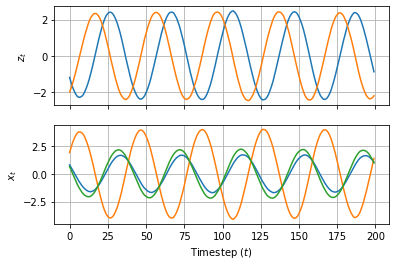

In [4]:
dataset_to_plot = 0
fig, axes = plt.subplots(2, 1, sharex=True, squeeze=True)
axes[0].plot(true_states[dataset_to_plot])
axes[0].grid(True)
axes[0].set_ylabel('$z_t$')
axes[1].plot(data[dataset_to_plot])
axes[1].grid(True)
axes[1].set_ylabel('$x_t$')
plt.xlabel('Timestep ($t$)')
plt.pause(0.1)

# 2. Inference Over Latent State

#### Inference baseline: Use EM to infer the exact posterior over latent state given observes.

In [5]:
# Test against EM (which for the LDS is exact.
em_posterior = jax.vmap(model.infer_posterior)(data)
em_log_marginal_likelihood = model.marginal_likelihood(data, posterior=em_posterior)

#### Inference: Infer the posterior over latent state given observes.

In [6]:
num_particles = 10000  # Number of particles to use in SMC sweeps.
n_repeats = 2         # Number of repeats for each dataset (independent trials).

key, subkey = jax.random.split(key)

# Define a wrapper for SMC sweep using BPF.
repeat_smc = lambda _k: smc(_k, model, data, proposal=None, num_particles=num_particles)

# Compute the posteriors.
smoothing_particles, log_marginal_likelihood, ancestry, filtering_particles = jax.vmap(repeat_smc)(jax.random.split(subkey, num=n_repeats))

# # Print the estimated marginals.
# for _smc, _em in zip(log_marginal_likelihood.T, em_log_marginal_likelihood):
#     for __smc in _smc:
#         print('SMC/EM LML: \t {: >6.4f} \t {: >6.4f}'.format(__smc, _em))
#     print()

#### Plot the results of inference for a single sweep

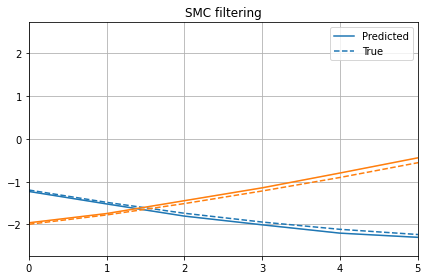

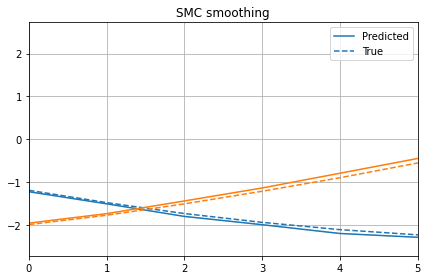

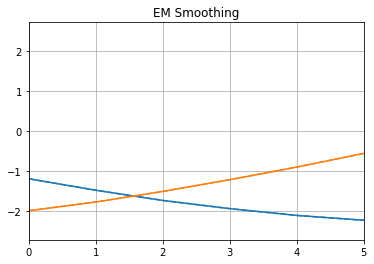

In [7]:
importlib.reload(test_smc)

# Which repeat and dataset to plot.
rep = 0
dset = 0

# Pull out the right sweeps.
sweep_smc_filtering = filtering_particles[rep, dset]
sweep_smc_smoothing = smoothing_particles[rep, dset]
sweep_em_mean = em_posterior.mean()[dset]
sweep_em_sds = jnp.sqrt(jnp.asarray([[jnp.diag(__k) for __k in _k] for _k in em_posterior.covariance()]))[dset]
sweep_true = true_states[dset]

# Plot the SMC distributions.
test_smc.plot_single_sweep(sweep_smc_filtering, sweep_true, tag='SMC filtering')
test_smc.plot_single_sweep(sweep_smc_smoothing, sweep_true, tag='SMC smoothing')

# Now plot the EM distributions.
x = range(sweep_true.shape[0])
plt.figure()
for _idx, _c in zip(range(len(sweep_em_mean.T)), test_smc.color_names):
    plt.plot(x, sweep_em_mean[:, _idx], c=_c)
    plt.fill_between(x, sweep_em_mean[:, _idx] - sweep_em_sds[:, _idx], sweep_em_mean[:, _idx] + sweep_em_sds[:, _idx], color=_c, alpha=0.1)
    plt.plot(x, sweep_true[:, _idx], c=_c, linestyle='--')
plt.grid(True)
plt.title('EM Smoothing')
plt.xlim(0, 5)
plt.pause(0.001)

# 4. Verify ML Estimations

This box-and-whisker plot shows the log-marginal likelihoods, as they are generally better scaled and easier to visualize.  Note however that SMC does not produce an unbiased estimate of the log marginal likelihoods (c.f. Jensens inequality), and therefore this is just for back-of-the-envelope verification that the LML estimations are sensible...

The boxes are over the estimate of the LML generated by SMC (of which there are `n_repeats` individual estimates) for each trial (of which there are `num_trials`).

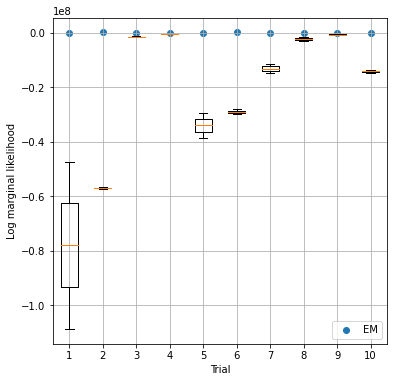

In [8]:
plt.figure(figsize=(6, 6))
plt.boxplot(log_marginal_likelihood.T, showfliers=False)
plt.grid(True)
plt.scatter(jnp.arange(len(log_marginal_likelihood.T)) + 1, em_log_marginal_likelihood, label='EM')
plt.legend()
plt.ylabel('Log marginal likelihood')
plt.xlabel('Trial')
plt.pause(0.1)

In [9]:
# Compute the log marginals for SMC.
smc_elml = jscipy.special.logsumexp(log_marginal_likelihood, axis=0)

In [10]:
print('|-------------------------------------|')
print('| Trial, i: |  log E [p(x_i | theta)] |')
print('|           |-------------------------|')
print('|           |     SMC    |     EM     |')
print('|-----------|------------|------------|')
for _idx, _smc, _em in zip(range(len(smc_elml)), smc_elml, em_log_marginal_likelihood):
    print('|   {: >3d}  '.format(_idx),
          '  |  {: >6.2f} '.format(jscipy.special.logsumexp(_smc)), 
          '  |  {: >6.2f} '.format(jscipy.special.logsumexp(_em)), 
          '  |  ')
print('|-------------------------------------|')

|-------------------------------------|
| Trial, i: |  log E [p(x_i | theta)] |
|           |-------------------------|
|           |     SMC    |     EM     |
|-----------|------------|------------|
|     0     |  -47280176.00    |  14332.86    |  
|     1     |  -56761284.00    |  38920.18    |  
|     2     |  -1390111.75    |  1031.78    |  
|     3     |  -384884.09    |  1800.10    |  
|     4     |  -29365220.00    |  -2043.96    |  
|     5     |  -28114160.00    |  51214.70    |  
|     6     |  -11391636.00    |  -14350.14    |  
|     7     |  -1705952.25    |  -1015.21    |  
|     8     |  -561992.56    |  2800.49    |  
|     9     |  -13649839.00    |  4096.62    |  
|-------------------------------------|


In [11]:
lml_diff = smc_elml - em_log_marginal_likelihood
print('raw', lml_diff)
print("corection:", jnp.exp(lml_diff).mean(), jnp.log(jnp.exp(lml_diff).mean()))
lml_diff = smc_elml - em_log_marginal_likelihood - jnp.log(jnp.exp(lml_diff).mean())
print('corrected:', lml_diff)
print("cor2: ", jnp.exp(lml_diff).mean())


raw [-47294508.   -56800204.    -1391143.5    -386684.2  -29363176.
 -28165374.   -11377286.    -1704937.     -564793.06 -13653936.  ]
corection: 0.0 -inf
corrected: [inf inf inf inf inf inf inf inf inf inf]
cor2:  inf


# 5. Verify ML Estimations across models

What we did above was conditioned on a single model ($\theta$), and so we need to repeat this estimation across models.  We will therefore average over trials and repeats, conditioned on individual models.

In [12]:
def test_single_model(key):
    
    # Generate a new model and data.
    key, subkey = jax.random.split(key)
    model = GaussianLDS(num_latent_dims=latent_dim, num_emission_dims=emissions_dim, seed=subkey, emission_scale_tril=1.0**2 * jnp.eye(emissions_dim))
    key, subkey = jax.random.split(key)
    true_states, data = model.sample(key=subkey, num_steps=num_timesteps, num_samples=num_trials)

    # Test against EM (which for the LDS is exact.
    em_posterior = jax.vmap(model.infer_posterior)(data)
    em_log_marginal_likelihood = model.marginal_likelihood(data, posterior=em_posterior)

    # Compute the posteriors using SMC.
    key, subkey = jax.random.split(key)
    repeat_smc = lambda _k: smc(_k, model, data, proposal=None, num_particles=num_particles)
    _, log_marginal_likelihood, _, _ = jax.vmap(repeat_smc)(jax.random.split(subkey, num=n_repeats))
    
    return log_marginal_likelihood, em_log_marginal_likelihood

In [ ]:
# num_timesteps = 200    # Number of timesteps in each trial.
# num_particles = 500    # Number of particles to use in SMC sweeps.
# num_trials = 20        # Number of trials to draw per model.
# n_repeats = 10         # Number of repeats for each dataset (independent SMC runs).
n_models_to_test = 5   # Number of random models to test.

key, subkey = jax.random.split(key)
smc_lmls, em_lmls = jax.vmap(test_single_model)(jax.random.split(key, num=n_models_to_test))

mean_smc_lml = jnp.mean(smc_lmls, axis=(1, 2))
mean_em_lml = jnp.mean(em_lmls, axis=1)

In [ ]:
print('|-------------------------------------|')
print('| Model, i: | log E [ p( theta_i ) ]  |')
print('|           |-------------------------|')
print('|           |     SMC    |     EM     |')
print('|-----------|------------|------------|')
for _idx, _smc, _em in zip(range(len(mean_smc_lml)), mean_smc_lml, mean_em_lml):
    print('|   {: >3d}  '.format(_idx),
          '  |  {: >5.2f}'.format(jscipy.special.logsumexp(_smc)), 
          '  |  {: >5.2f}'.format(jscipy.special.logsumexp(_em)), 
          '  |  ')
print('|-------------------------------------|')

In [ ]:
mean_smc_lml